<a href="https://colab.research.google.com/github/joyinning/causal_inference/blob/main/Causal_Week_7_1_(A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resource: https://matheusfacure.github.io/python-causality-handbook/20-Plug-and-Play-Estimators.html

# Chapter 20

## Concepts

### CATE (Conditional Average Treatment Effect)

**Question 1 Define ATE (Average Treatment Effect) and CATE (Conditional Average Treatment Effect). Why is CATE important in causal inference?**

- **ATE**: Average Treatment Effect, defined as the average effect of a treatment across all units, helping to determine the general efficacy of a treatment. It answers the question, "How effective is a treatment on average?"
- **CATE**: Conditional Average Treatment Effect, defined as the average effect of a treatment on a particular subgroup of units within a population, identifying how different subgroups respond differently to the treatment. It answers the question, "What if there are subgroups of units that respond better or worse to the treatment?"
- **Importance of CATE**: CATE is important because it allows for the personalization of decision-making by identifying subgroups that respond differently to a treatment, enhancing the precision and effectiveness of interventions.

**Question 2 What is the main drawback of using linear models to estiamte CATE? Then how can we solve this?**

- **Main Drawback**: The main drawback of linear models is their assumption of a linear relationship between features and outcomes, which can lead to inaccurate estimates if this relationship is not linear.
- **Solution**: We can solve this issue by employing more flexible machine learning models, such as boosted trees or neural networks, which can better capture complex, non-linear relationships.

**Question 3 What does it mean that the criteiron to minimize treatment effect MSE is infeasible?**

- **Explanation**: The criterion to minimize treatment effect MSE is infeasible because the true treatment effect is unobservable, preventing direct measurement and optimization.
- **Alternative Approach**: Instead, we use a machine learning regression model that, while not directly minimizing the outcome MSE, aims to minimize the treatment effect MSE through indirect methods.

### Target Transformation

**Binary Treatment Scenario**

**Question 4 What is the purpose of target transformation in the context of estimating treatment effect?**

- It is used to adjust the outcome variable in such a way that the transformed outcome becomes an unbiased estimator of the treatment effect, allowing the use of standard predictive models to estimate the tratment effects.

**Question 5 Why is random assignment important in the context of this study?**

- It is crucial because it ensures that the treatment assignment is independent of potential outcomes, which aids in obtaining unbiased estimates of treatment effects.

**Question 6 What is the role of the propensity score in the target transformation when the treatment is not uniformly assigned?**

- The propensity score adjusts the target transformation to account for the varying probabilities of receiving the treatment across different units. This ensures that the transformation remains an unbiased estimate of the treatment effect, even when treatment assignment is not uniform.

**Continous Treatment Scenario**

**Question 7 What target transformation is proposed for the continuous treatment case?**

- It involves normalizing the product of deviations of the treatment and the outcome from their respective means, potentially divided by the treatment variance (though this can be omitted if only the relative order of treatment effects is of interest).

**Question 8 How does random assignment of treatment help in estimating CATE for continuous treatment?**

- It ensure that the treatment is independent of other covariates across different units, which simplifies modeling by removing sconfounding biases and making it easier to interpret the relationship between treatment intensity and outcomes as causal.

### Non-Linear Treatment

**Question 9 How does the assumption of linearity in treatment effects pose a limitation in causal modeling, particularly in scenarios where treatment effects may not be linear?**

- In causal modeling, assuming linearity in treatment effects can be limiting because treatment effects often change with the level of the treatment itself, commonly exhibiting saturation or diminishing returns.
- This non-linearity means that different segments of the treatment (e.g., price range) can have varying elasticities, complicating the modeling and prediction of treatment effects across different conditions.

## Case Study

### Binary Treatment Scenario

***Using a drug treatment dataset, how can we identify which patient types exhibit a more positive response to the drug (higher CATE) and which may experience a negative response (CATE < 0)?***

**Dataset**

You can use the nb21 library.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot as plt
import seaborn as sns

In [127]:
import pandas as pd
import numpy as np

np.random.seed(432)
n_patients = 1000
ages = np.random.normal(50, 20, n_patients)
weights_kg = np.random.uniform(30, 100, n_patients)
weights_lb = weights_kg * 2.20462
comorbid = np.random.binomial(1, 0.2, n_patients)

# Binary Treatment Scenario
treatment = np.random.binomial(1, 0.5, n_patients)

# Calculating effect
effect = 2.0 * treatment - 0.05 * ages + 0.015 * weights_lb - 0.7 * comorbid * treatment + np.random.normal(0, 0.1, size=n_patients)
outcome = np.random.binomial(1, p=1 / (1 + np.exp(-effect)), size=n_patients)

data = pd.DataFrame({
    'age': ages,
    'weight': weights_lb,
    'comorbid': comorbid,
    'drug': treatment,
    'outcome': outcome
})

1. age: Age of the customer.
2. weight: Weight of the customer.
3. comorbid: Pre-existing medical conditions of the patient.
4. drug(treatment): The dosage of the drug administered to the patient, typically measured in milligrams or as a categorical variable indicating low, medium, or high dosage.
5. outcome: The response of the patient to the treatment, which could be measured as an improvement score, change in symptoms, or a binary variable indicating success (1) or failure (0) of the treament.

In [128]:
data.head()

,age,weight,comorbid,drug,outcome
0,53.737545,195.866326,0,0,1
1,50.689946,155.108131,1,1,1
2,42.304912,147.727213,1,1,1
3,59.291804,156.368332,0,1,1
4,62.017850,144.000016,0,0,0


**1 Split the data into training and testing sets** <br>

In [129]:
train, test = train_test_split(data, test_size=0.4, random_state=123)
print(train.shape, test.shape)

(600, 5) (400, 5)


**2 Apply the target transformation**

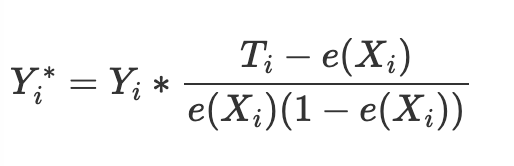

In [130]:
# Define variables
y = "outcome"
T = "drug"
X = ["age", "weight", "comorbid"]

# ps = the possibility of the treatment
ps = train[T].mean()

y_star_train = train[y] * (train[T] - ps)/(ps*(1-ps))

**3 Pick any ML regression algorithm and test the prediction**

In [ ]:
from lightgbm import LGBMRegressor

np.random.seed(123)
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)
cate_learner.fit(train[X], y_star_train);

In [132]:
test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,weight,comorbid,drug,outcome,cate
131,45.570996,87.970803,0,0,0,0.299526
203,76.140052,82.811405,0,1,0,0.340963
50,68.767191,148.920623,0,1,1,0.343255
585,102.851942,69.390843,0,1,0,0.340963
138,56.757926,161.773971,1,0,1,0.343255


**4 Plot and interpret the results**

In [133]:
def cumulative_gain(data, score_col, y_true, treatment_col):
    data = data.sort_values(by=score_col, ascending=False)
    data['cumulative_n'] = np.arange(1, len(data) + 1)
    data['cumulative_positive'] = data[y_true].cumsum()
    data['baseline'] = data[y_true].sum() * data['cumulative_n'] / len(data)
    return 100 * data['cumulative_positive'] / data[y_true].sum(), 100 * data['cumulative_n'] / len(data), 100 * data['baseline'] / data[y_true].sum()

def plot_cumulative_gain(data, score_col, y_true, treatment_col):
    gain_curve, percentiles, baseline = cumulative_gain(data, score_col, y_true, treatment_col)
    plt.figure(figsize=(8, 5))
    plt.plot(percentiles, gain_curve, label='Cumulative Gain', color='C0')
    plt.plot(percentiles, baseline, label='Baseline', linestyle='--', color='black')
    plt.xlabel('Percentage of Sample')
    plt.ylabel('Cumulative Gain')
    plt.title('Cumulative Gain Curve')
    plt.legend()
    plt.show()

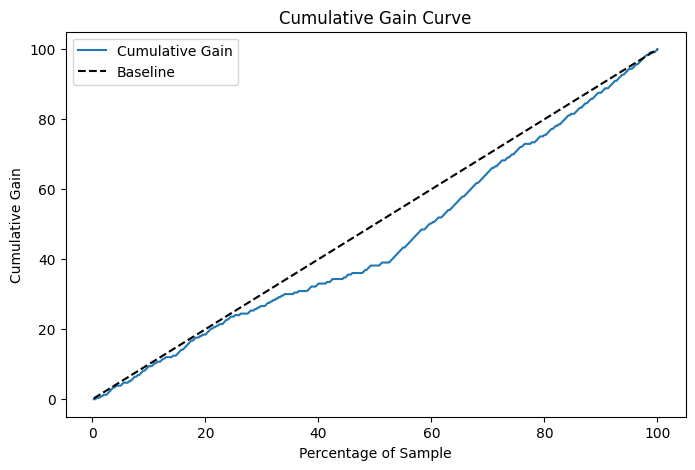

In [134]:
plot_cumulative_gain(test_pred, 'cate', 'outcome', 'drug')

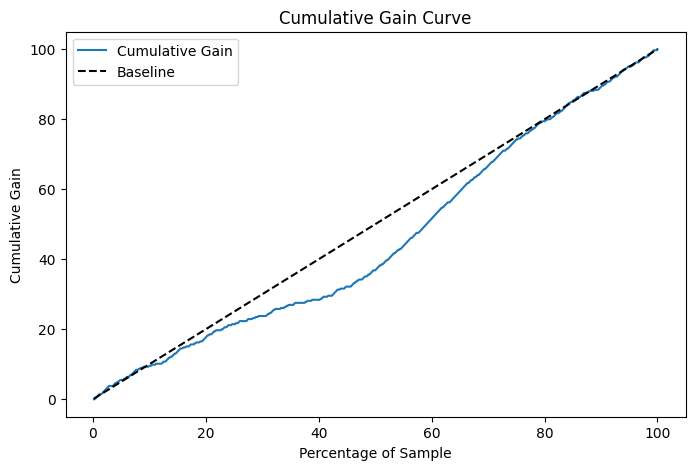

In [114]:
train_pred = train.assign(cate=cate_learner.predict(train[X]))
plot_cumulative_gain(train_pred, 'cate', 'outcome', 'drug')

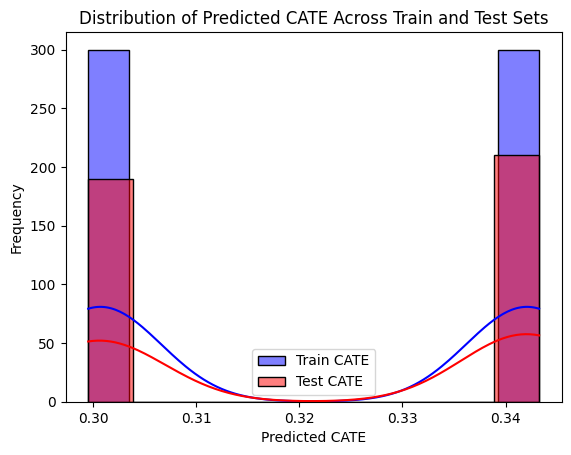

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train_pred['cate'], color="blue", label="Train CATE", kde=True)
sns.histplot(test_pred['cate'], color="red", label="Test CATE", kde=True)
plt.legend()
plt.title('Distribution of Predicted CATE Across Train and Test Sets')
plt.xlabel('Predicted CATE')
plt.ylabel('Frequency')
plt.show()

Given the CATE distribution primarily between 0.300.31 and 0.330.34 with no values below zero, it seems your model is not predicting any negative treatment effects (CATE < 0). This suggests that, according to your model, the drug has a positive effect on all patients, although the effect size varies slightly within a narrow range.

### Continuous Treatment Scenario

***Using a continuous drug dosage dataset, how can we identify which patient types exhibit a more positive response to varying drug dosages (higher CATE) and which may experience a negative response (CATE < 0)***

In [38]:
np.random.seed(432)
n_patients = 1000
ages2 = np.random.normal(50, 12, n_patients)
weights2 = np.random.normal(70, 15, n_patients)
comorbid2 = np.random.binomial(1, 0.3, n_patients)

# Simulating treatment assignment randomly
treatment2 = np.random.uniform(0, 10, n_patients)

# Generating outcome variable
effect2 = 0.05 * treatment2 - 0.02 * ages2 + 0.01 * weights2 - 0.3 * comorbid2 * treatment2
outcome2 = 3 + effect2 + np.random.normal(0, 0.5, n_patients)

data2 = pd.DataFrame({
    'age': ages2,
    'weight': weights2,
    'comorbid': comorbid2,
    'dosage': treatment2,
    'outcome': outcome2
})
data2.head()

,age,weight,comorbid,dosage,outcome
0,52.242527,73.940734,0,3.795477,3.377968
1,50.413968,87.543337,1,8.082877,0.274842
2,45.382947,107.279829,1,7.512134,1.233145
3,55.575082,82.628876,0,9.246233,3.179673
4,57.210710,17.748515,0,1.891829,0.734581


- age: Age of the customer.
- weight: Weight of the customer.
- comorbid: Pre-existing medical conditions of the patient.
- drug (treatment): The dosage of the drug administered to the patient, typically measured in milligrams or as a continuous scale. This variable quantifies the amount of medication each patient receives, which is crucial for analyzing dose-response relationships and determining optimal dosing strategies.
- outcome: The response of the patient to the treatment, which could be measured as an improvement score or change in symptoms. This outcome is generally numeric and represents a measure of treatment effectiveness based on the administered dosage.

In [51]:
data2.groupby('comorbid').size()

comorbid
0    706
1    294
dtype: int64

**1 Create a Model for Conditional Average Treatment Effect** <br>

In [49]:
np.random.seed(123)
train2, test2 = train_test_split(data2, test_size=0.3)
train2.shape, test2.shape

((700, 5), (300, 5))

**2 Apply the target transformation**

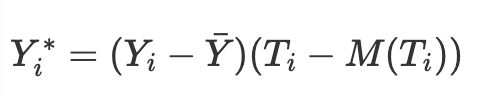

In [55]:
y_star_cont2 = (train2["dosage"] - train2["dosage"].mean()
               *train2["outcome"] - train2["outcome"].mean())

**3 Pick any ML regression algorithm and test the prediction**

In [ ]:
np.random.seed(123)
cate_learner2 = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)
cate_learner2.fit(train2[["age", "weight", "comorbid"]], y_star_cont2)

cate_test_transf_y = cate_learner2.predict(test2[["age", "weight", "comorbid"]])

test_pred2 = test2.assign(cate=cate_test_transf_y)

In [59]:
test_pred2.sample(5)

,age,weight,comorbid,dosage,outcome,cate
801,52.365604,67.682159,1,6.470071,1.341909,-8.298285
313,34.551444,61.945148,0,6.746521,2.521910,-10.865664
485,49.587684,51.984003,0,1.555329,2.800688,-10.103455
995,49.580296,40.000044,0,2.275701,2.451695,-10.103455
723,35.704816,48.556640,0,7.813394,3.126033,-10.865664


**4 Plot and interpret the results**

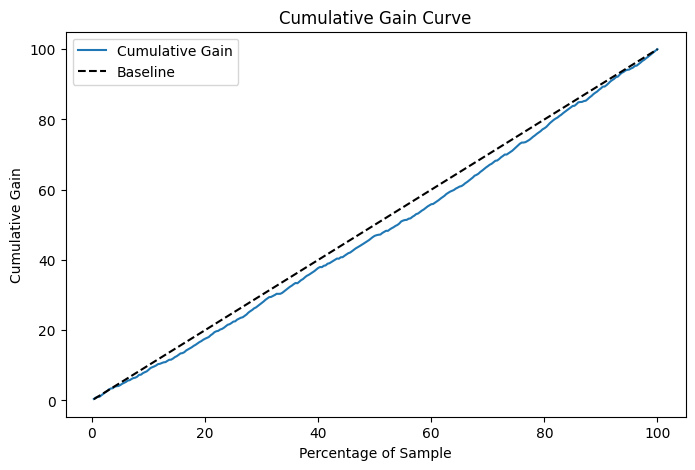

In [60]:
plot_cumulative_gain(test_pred2, 'cate', 'outcome', 'dosage')

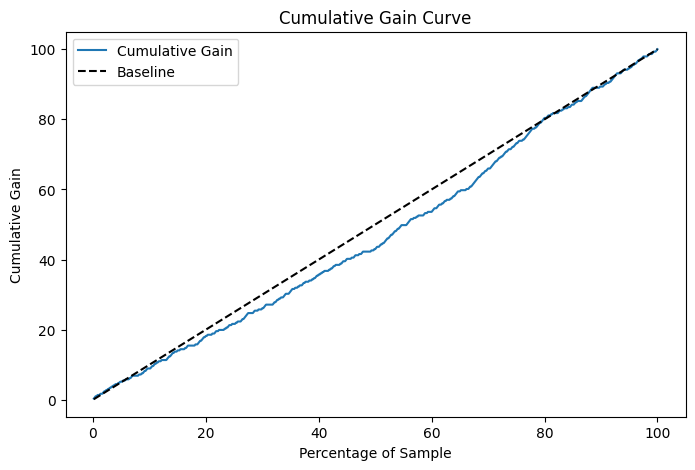

In [61]:
train_pred2 = train2.assign(cate=cate_learner2.predict(train2[X]))
plot_cumulative_gain(train_pred, 'cate', 'outcome', 'dosage')

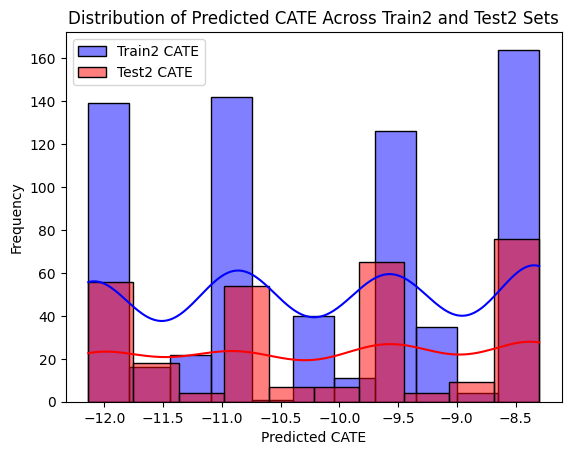

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train_pred2['cate'], color="blue", label="Train2 CATE", kde=True)
sns.histplot(test_pred2['cate'], color="red", label="Test2 CATE", kde=True)
plt.legend()
plt.title('Distribution of Predicted CATE Across Train2 and Test2 Sets')
plt.xlabel('Predicted CATE')
plt.ylabel('Frequency')
plt.show()

- Negative values would indicate instances where the drug dosage has a detrimental effect compared to some baseline or control condition.
- Major differences could indicate overfitting, where the model performs well on the training data but poorly on unseen test data.